# Kaggle's Titanic dataset classification

## Initialization & imports

In [76]:
import sys, itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from time import time

from customhelpers import EstimatorSelectionHelper, plot_confusion_matrix

from IPython.display import display, Markdown

## Pandas & seaborn config

In [77]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('chained_assignment', None)

sns.set(style="dark", palette="hls")

## Options

In [78]:
opt_generate_plots            = False
opt_get_pca_features          = False
opt_estimate_best_classifier  = False
opt_remove_outliers           = False
opt_find_best_random_state    = False

## Features & labels

In [79]:
raw_features     = ['Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass', 'Sex', 'Cabin', 'Ticket', 'Name']
labels           = ['Survived']
datacolumns      = raw_features+labels

## CSV Reading

In [80]:
print "Reading CSV..."
df = pd.read_csv("../data/input/train.csv")

Reading CSV...


## Data exploration

In [81]:
display(Markdown("### Info"))
print df.info()
display(Markdown("### Null counts"))
print df.isnull().sum(axis=0)
display(Markdown("### Describe"))
print df.describe()
display(Markdown("### Sex counts"))
print df['Sex'].dropna().value_counts()
display(Markdown("### Cabin counts"))
print df['Cabin'].fillna('?').apply(lambda x: x[0]).value_counts()
display(Markdown("### Survived counts"))
print df['Survived'].dropna().value_counts()
display(Markdown("### Embarked counts"))
print df['Embarked'].dropna().value_counts()
display(Markdown("### Correlation"))
print df.corr()

### Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


### Null counts

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Describe

       PassengerId    Survived      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


### Sex counts

male      577
female    314
Name: Sex, dtype: int64


### Cabin counts

?    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64


### Survived counts

0    549
1    342
Name: Survived, dtype: int64


### Embarked counts

S    644
C    168
Q     77
Name: Embarked, dtype: int64


### Correlation

             PassengerId  Survived    Pclass       Age     SibSp     Parch      Fare
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652  0.012658
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159651
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000  0.216225
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000


## Histogram

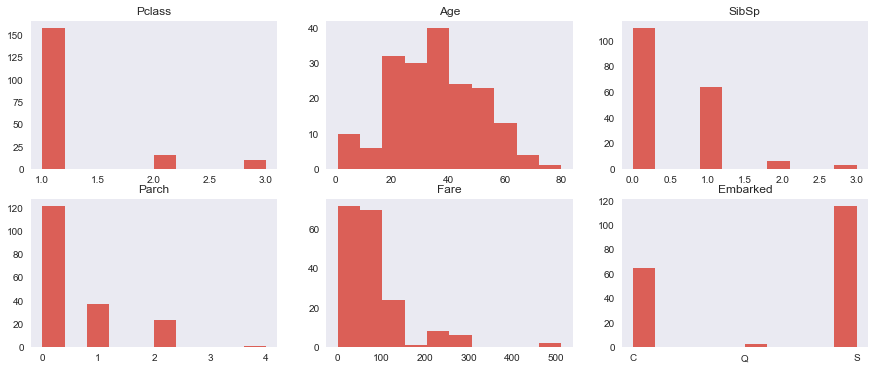

In [82]:
fig, axes = plt.subplots(2,3,figsize=(15,6))
for ax, feature in itertools.izip_longest(axes.flatten(), ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']):
    if(feature):
        ax.hist(df.dropna()[feature])
        ax.set_title(feature)

## Analysis plots (optional)

In [83]:
if(opt_generate_plots):
    print "\n> Creating plots"
    fg = sns.FacetGrid(df, hue="Survived", size=5, aspect=1.61)
    fg.map(plt.scatter, "Age", "Fare")
    fg.add_legend()
    fg.savefig("../data/output/age_fare_survived.png")

    fg = sns.FacetGrid(df, hue="Pclass", size=5, aspect=1.61)
    fg.map(plt.scatter, "Age", "Fare")
    fg.add_legend()
    fg.savefig("../data/output/age_fare_pclass.png")

    # Boxplot
    df[datacolumns].plot(kind='box', subplots=True, layout=(2, 5), figsize=(14, 12), sharex=False, sharey=False, sym="bo")
    plt.savefig("../data/output/univariate.png")

    # Pairplots
    sns_plot = sns.pairplot(df[datacolumns].dropna(), size=5, hue="Survived")
    sns_plot.savefig("../data/output/pairplot.png")
    print "Saved to file"

## Dataframe process function

In [84]:
def processDataFrame(df):

    def processTicket(ticket):
        ticket = ticket.split(' ')[-1]
        return int(ticket) if ticket.isdigit() else 0

    scale_features  = ['Age', 'SibSp', 'Parch', 'Fare', 'Ticket']
    encode_features = ['Embarked','Pclass','Sex', 'Cabin', 'Name']# , 'Ticket'

    # NaN filling
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode(), inplace=True)
    df['Cabin'].fillna('Unknown', inplace=True)
    
    # Feature editing
    df['Cabin']  = df['Cabin'].apply(lambda x: x[0])
    df['Name']   = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['Ticket'] = df['Ticket'].apply(processTicket)

    # One-hot encoding
    pre_features = df.columns.values
    df = pd.get_dummies(df, columns=encode_features)
    post_features = df.columns.values
    diff_features = list(set(post_features) - set(pre_features))

    # Drop other NaNs
    df = df.dropna()

    # Standarization
    scaler = StandardScaler()
    df[scale_features+diff_features] = scaler.fit_transform(df[scale_features+diff_features].as_matrix())

    # PCA
    if(opt_get_pca_features):
        pca = PCA(n_components=3)
        components = pca.fit_transform(df)
        df = pd.DataFrame(components, columns=["col" + str(n) for n in xrange(pca.n_components_)])

    return df

## Preprocess

In [85]:
print "Processing DataFrame..."
df = processDataFrame(df[datacolumns])
y  = df[labels]
X  = df.drop(columns=labels)

Processing DataFrame...


## Outlier removal (optional)

In [86]:
if(opt_remove_outliers):
    lof = LocalOutlierFactor(n_neighbors=5)
    outliers = lof.fit_predict(X)
    print "Removing %i outliers" % np.count_nonzero(outliers==-1)
    X = X[outliers==1]
    y = y[outliers==1]

## Splitting

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Estimation of best classifier and best parameters (optional)

In [88]:
if(opt_estimate_best_classifier):
    t0 = time()
    print "\n> Estimation of best classifier and best parameters..."

    classifiers = {
        'KNeighborsClassifier': KNeighborsClassifier(),
        'SVC': SVC(),
        'DecisionTreeClassifier': DecisionTreeClassifier(),
        'RandomForestClassifier': RandomForestClassifier(),
        'AdaBoostClassifier': AdaBoostClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'GaussianNB': GaussianNB()
    }

    hyperparameters = {
        'KNeighborsClassifier': { 'n_neighbors': [2,5,10,15] },
        'SVC': [
            { 'kernel': ['linear'], 'C': [0.1, 1, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1] },
            { 'kernel': ['rbf'], 'C': [0.1, 1, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1] },
        ],
        'DecisionTreeClassifier': { 'min_samples_split': [2,5,10,100] },
        'RandomForestClassifier': { 'n_estimators': [16, 32, 64, 100, 200] },
        'AdaBoostClassifier': { 'n_estimators': [32, 64, 100, 200], 'learning_rate': [0.8, 1.0] },
        'GradientBoostingClassifier': { 'n_estimators': [32, 64, 100, 200], 'learning_rate': [0.8, 1.0] },
        'GaussianNB': { }
    }

    estimator = EstimatorSelectionHelper(classifiers, hyperparameters)
    estimator.fit(X_train, y_train.values.ravel(), scoring='accuracy', verbose=1)
    print "(done in %0.3fs)" % (time() - t0)

    print estimator.score_summary(sort_by='min_score')

## Find best random state for random forest (optional)

In [89]:
if(opt_find_best_random_state):
    for i in xrange(1,256):
        clf = RandomForestClassifier(n_estimators=32, random_state=i)
        clf.fit(X_train, y_train.values.ravel())
        sco = clf.score(X_test, y_test)
        if(sco > 0.85):
            print "Classifier accuracy random_state=%i:" % i, sco

## Random Forest classifier training + predictions & score + cross validation

In [90]:
print "Training classifier..."
clf = RandomForestClassifier(n_estimators=32, random_state=181) # Best accuracy: 0.860335195531
clf.fit(X_train, y_train.values.ravel())
score = clf.score(X_test, y_test)
print "- Selected classifier accuracy:", score

print "Computing cross validated scores..."
scores = cross_val_score(clf, X, y.values.ravel(), cv=5)
print "- Cross validated accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), scores

y_pred = clf.predict(X_test)

Training classifier...
- Selected classifier accuracy: 0.8603351955307262
Computing cross validated scores...
- Cross validated accuracy: 0.82 (+/- 0.04) [0.82122905 0.80446927 0.84831461 0.79775281 0.85310734]


## Confusion matrix (optional)

Confusion matrix, without normalization
[[96  9]
 [16 58]]


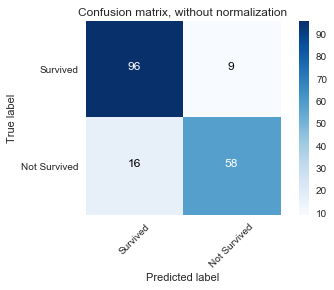

In [91]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['Survived','Not Survived'], title='Confusion matrix, without normalization')

## Classification report

In [92]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.86      0.91      0.88       105
          1       0.87      0.78      0.82        74

avg / total       0.86      0.86      0.86       179



## Compute ROC curve and AUC

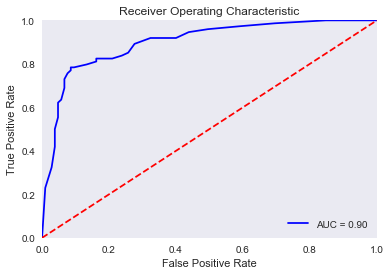

In [93]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Predicting new data

In [94]:
print "Reading test CSV..."
df_pred = pd.read_csv("../data/input/test.csv")

Reading test CSV...


## Preprocessing with feature diff & intersection

In [95]:
features = X.columns.values
X_pred = processDataFrame(df_pred[raw_features])
pred_features = X_pred.columns.values
features_to_add = [f for f in features if f not in pred_features]
colvalues = dict.fromkeys(features_to_add, 0)
X_pred = X_pred.assign(**colvalues)
X_pred = X_pred[features]

## Predictions & probability on the new data

Predicting 417 samples...
* Survived: 146
* Not-Survived: 271
* Survived with probability beyond 80%: 93


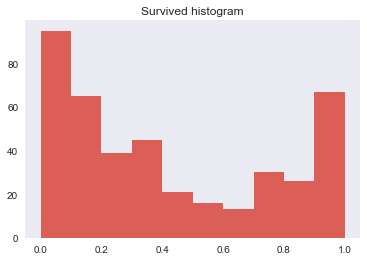

In [96]:
print "Predicting %i samples..." % X_pred.shape[0]
test_pred = clf.predict(X_pred)
test_proba = clf.predict_proba(X_pred)
print "* Survived:", np.count_nonzero(test_pred==1)
print "* Not-Survived:", np.count_nonzero(test_pred==0)
survived = test_proba[:,1]
plt.hist(survived)
plt.title("Survived histogram")
print "* Survived with probability beyond 80%:", np.count_nonzero(survived > 0.8)